In [ ]:
from glob import glob
from google.colab import drive
drive.mount('/content/drive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [ ]:
!pip install augmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import nibabel as nib
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from augmentation import *

def load_img(img_files):
    ''' Load one image and its target form file
    '''
    N = len(img_files)
    # target
    y = nib.load(img_files[N-1]).get_fdata(dtype='float32', caching='unchanged')
    y = y[40:200,34:226,8:136]
    y[y==4]=3
      
    X_norm = np.empty((240, 240, 155, 4))
    for channel in range(N-1):
        X = nib.load(img_files[channel]).get_fdata(dtype='float32', caching='unchanged')
        brain = X[X!=0] 
        brain_norm = np.zeros_like(X) # background at -100
        norm = (brain - np.mean(brain))/np.std(brain)
        brain_norm[X!=0] = norm
        X_norm[:,:,:,channel] = brain_norm        
        
    X_norm = X_norm[40:200,34:226,8:136,:]    
    del(X, brain, brain_norm)
    
    return X_norm, y
    
def visualize(X):
    """
    Visualize the image middle slices for each axis
    """
    a,b,c = X.shape
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.imshow(np.rot90(X[a//2, :, :]), cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(np.rot90(X[:, b//2, :]), cmap='gray')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(X[:, :, c//2], cmap='gray')
    plt.axis('off')
    
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=4, dim=(160,192,128), n_channels=4, n_classes=4, shuffle=True, augmentation=False, patch_size=128, n_patches=1):
        'Initialization'
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data     
        X, y = self.__data_generation(list_IDs_temp)
        if self.augmentation == True:
            X, y = self.__data_augmentation(X, y)
        
        if index == self.__len__()-1:
            self.on_epoch_end()
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
  
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, IDs in enumerate(list_IDs_temp):
            # Store sample
            X[i], y[i] = load_img(IDs)
            
        if self.augmentation == True:
            return X.astype('float32'), y
        else:
            return X.astype('float32'), to_categorical(y, self.n_classes)

    def __data_augmentation(self, X, y):
        'Apply augmentation'
        X_aug, y_aug = patch_extraction(X, y, sizePatches=self.patch_size, Npatches=self.n_patches)
        #X_aug, y_aug = aug_batch(X_aug, y_aug)
                
        return X_aug, to_categorical(y_aug, self.n_classes)

In [ ]:
!pip install elasticdeform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 2.1 MB/s 


In [ ]:
import numpy as np
from scipy.ndimage.interpolation import affine_transform
import elasticdeform
import multiprocessing as mp

def patch_extraction(Xb, yb, sizePatches=128, Npatches=1):
    """
    3D patch extraction
    """
    
    batch_size, rows, columns, slices, channels = Xb.shape
    X_patches = np.empty((batch_size*Npatches, sizePatches, sizePatches, sizePatches, channels))
    y_patches = np.empty((batch_size*Npatches, sizePatches, sizePatches, sizePatches))
    i = 0
    for b in range(batch_size):
        for p in range(Npatches):
            x = np.random.randint(rows-sizePatches+1) 
            y = np.random.randint(columns-sizePatches+1)
            z = np.random.randint(slices-sizePatches+1) 

            X_patches[i] = Xb[b, x:x+sizePatches, y:y+sizePatches, z:z+sizePatches, :]
            y_patches[i] = yb[b, x:x+sizePatches, y:y+sizePatches, z:z+sizePatches]
            i += 1
                               
    return X_patches, y_patches

def flip3D(X, y):
    """
    Flip the 3D image respect one of the 3 axis chosen randomly
    """
    choice = np.random.randint(3)
    if choice == 0: # flip on x
        X_flip, y_flip = X[::-1, :, :, :], y[::-1, :, :]
    if choice == 1: # flip on y
        X_flip, y_flip = X[:, ::-1, :, :], y[:, ::-1, :]
    if choice == 2: # flip on z
        X_flip, y_flip = X[:, :, ::-1, :], y[:, :, ::-1]
        
    return X_flip, y_flip


def rotation3D(X, y):
    """
    Rotate a 3D image with alfa, beta and gamma degree respect the axis x, y and z respectively.
    The three angles are chosen randomly between 0-30 degrees
    """
    alpha, beta, gamma = np.pi*np.random.random_sample(3,)/2
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])
    
    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                   [np.sin(gamma), np.cos(gamma), 0],
                   [0, 0, 1]])
    
    R = np.dot(np.dot(Rx, Ry), Rz)
    
    X_rot = np.empty_like(X)
    for channel in range(X.shape[-1]):
        X_rot[:,:,:,channel] = affine_transform(X[:,:,:,channel], R, offset=0, order=3, mode='constant')
    y_rot = affine_transform(y, R, offset=0, order=0, mode='constant')
    
    return X_rot, y_rot

def brightness(X, y):
    """
    Changing the brighness of a image using power-law gamma transformation.
    Gain and gamma are chosen randomly for each image channel.
    
    Gain chosen between [0.9 - 1.1]
    Gamma chosen between [0.9 - 1.1]
    
    new_im = gain * im^gamma
    """
    
    X_new = np.zeros(X.shape)
    for c in range(X.shape[-1]):
        im = X[:,:,:,c]        
        gain, gamma = (1.2 - 0.8) * np.random.random_sample(2,) + 0.8
        im_new = np.sign(im)*gain*(np.abs(im)**gamma)
        X_new[:,:,:,c] = im_new 
    
    return X_new, y

def elastic(X, y):
    """
    Elastic deformation on a image and its target
    """  
    [Xel, yel] = elasticdeform.deform_random_grid([X, y], sigma=2, axis=[(0, 1, 2), (0, 1, 2)], order=[1, 0], mode='constant')
    
    return Xel, yel

def random_decisions(N):
    """
    Generate N random decisions for augmentation
    N should be equal to the batch size
    """
    
    decisions = np.zeros((N, 4)) # 4 is number of aug techniques to combine (patch extraction excluded)
    for n in range(N):
        decisions[n] = np.random.randint(2, size=4)
        
    return decisions

def combine_aug(X, y, do):
    """
    Combine randomly the different augmentation techniques written above
    """
    Xnew, ynew = X, y
    
    # make sure to use at least the 25% of original images
    if np.random.random_sample()>0.75:
        return Xnew, ynew
    
    else:   
        if do[0] == 1:
            Xnew, ynew = flip3D(Xnew, ynew)

        if do[1] == 1:
            Xnew, ynew = brightness(Xnew, ynew)   

        if do[2] == 1:
            Xnew, ynew = rotation3D(Xnew, ynew)

        if do[3] == 1:
            Xnew, ynew = elastic(Xnew, ynew)
        
        return Xnew, ynew

def aug_batch(Xb, Yb):
    """
    Generate a augmented image batch 
    """
    batch_size = len(Xb)
    newXb, newYb = np.empty_like(Xb), np.empty_like(Yb)
    
    decisions = random_decisions(batch_size)            
    inputs = [(X, y, do) for X, y, do in zip(Xb, Yb, decisions)]
    pool = mp.Pool(processes=8)
    multi_result = pool.starmap(combine_aug, inputs)
    pool.close()
    
    for i in range(len(Xb)):
        newXb[i], newYb[i] = multi_result[i][0], multi_result[i][1]
        
    return newXb, newYb 

In [ ]:
import tensorflow as tf

def diceLoss(y_true, y_pred, class_weights):
    y_true = tf.convert_to_tensor(y_true, 'float32')
    y_pred = tf.convert_to_tensor(y_pred, y_true.dtype)

    num = tf.math.reduce_sum(tf.math.multiply(class_weights, tf.math.reduce_sum(tf.math.multiply(y_true, y_pred), axis=[0,1,2,3])))
    den = tf.math.reduce_sum(tf.math.multiply(class_weights, tf.math.reduce_sum(tf.math.add(y_true, y_pred), axis=[0,1,2,3])))+1e-5

    return 1-2*num/den

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = tf.math.reduce_mean(tf.math.pow(tf.ones_like(disc_real_output) - disc_real_output, 2))
    fake_loss = tf.math.reduce_mean(tf.math.pow(tf.zeros_like(disc_fake_output) - disc_fake_output, 2))

    disc_loss = 0.5*(real_loss + fake_loss)

    return disc_loss


def generator_loss(target, gen_output, disc_fake_output, class_weights, alpha):
    
    # generalized dice loss
    dice_loss = diceLoss(target, gen_output, class_weights)
    
    # disc loss
    disc_loss = tf.math.reduce_mean(tf.math.pow(tf.ones_like(disc_fake_output) - disc_fake_output, 2))
       
    # total loss
    gen_loss = alpha*dice_loss + disc_loss

    return gen_loss, dice_loss, disc_loss

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.6 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Conv3D, Conv3DTranspose, Dropout, ReLU, LeakyReLU, Concatenate, ZeroPadding3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization
   
def Generator():
    '''
    Generator model
    '''
    def encoder_step(layer, Nf, ks, norm=True):
        x = Conv3D(Nf, kernel_size=ks, strides=2, kernel_initializer='he_normal', padding='same')(layer)
       # x = Conv3D(Nf, kernel_size=ks, strides=2, kernel_initializer='he_normal', padding='same')(layer)
        if norm:
            x = InstanceNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.2)(x)

        return x

    def bottlenek(layer, Nf, ks):
        x = Conv3D(Nf, kernel_size=ks, strides=2, kernel_initializer='he_normal', padding='same')(layer)
        x = InstanceNormalization()(x)
        x = LeakyReLU()(x)
        for i in range(4):
            y = Conv3D(Nf, kernel_size=ks, strides=1, kernel_initializer='he_normal', padding='same')(x)
            x = InstanceNormalization()(y)
            x = LeakyReLU()(x)
            x = Concatenate()([x, y])

        return x

    def decoder_step(layer, layer_to_concatenate, Nf, ks):
        x = Conv3DTranspose(Nf, kernel_size=ks, strides=2, padding='same', kernel_initializer='he_normal')(layer)
        x = InstanceNormalization()(x)
        x = LeakyReLU()(x)
        x = Concatenate()([x, layer_to_concatenate])
        x = Dropout(0.2)(x)
        return x

    layers_to_concatenate = []
    inputs = Input((128,128,128,4), name='input_image')
    Nfilter_start = 64
    depth = 4
    ks = 4
    x = inputs

    # encoder
    for d in range(depth-1):
        if d==0:
            x = encoder_step(x, Nfilter_start*np.power(2,d), ks, False)
            #x = encoder_step(x, Nfilter_start*np.power(2,d), ks, False)
        else:
            x = encoder_step(x, Nfilter_start*np.power(2,d), ks)
        layers_to_concatenate.append(x)

    # bottlenek
    x = bottlenek(x, Nfilter_start*np.power(2,depth-1), ks)

    # decoder
    for d in range(depth-2, -1, -1): 
        x = decoder_step(x, layers_to_concatenate.pop(), Nfilter_start*np.power(2,d), ks)

    # classifier
    last = Conv3DTranspose(4, kernel_size=ks, strides=2, padding='same', kernel_initializer='he_normal', activation='softmax', name='output_generator')(x)
   
    return Model(inputs=inputs, outputs=last, name='Generator')

def Discriminator():
    '''
    Discriminator model
    '''

    inputs = Input((128,128,128,4), name='input_image')
    targets = Input((128,128,128,4), name='target_image')
    Nfilter_start = 64
    depth = 3
    ks = 4

    def encoder_step(layer, Nf, norm=True):
        x = Conv3D(Nf, kernel_size=ks, strides=2, kernel_initializer='he_normal', padding='same')(layer)
        if norm:
            x = InstanceNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.2)(x)
        
        return x

    x = Concatenate()([inputs, targets])

    for d in range(depth):
        if d==0:
            x = encoder_step(x, Nfilter_start*np.power(2,d), False)
        else:
            x = encoder_step(x, Nfilter_start*np.power(2,d))
            
    x = ZeroPadding3D()(x)
    x = Conv3D(Nfilter_start*(2**depth), ks, strides=1, padding='valid', kernel_initializer='he_normal')(x) 
    x = InstanceNormalization()(x)
    x = LeakyReLU()(x)
      
    x = ZeroPadding3D()(x)
    last = Conv3D(1, ks, strides=1, padding='valid', kernel_initializer='he_normal', name='output_discriminator')(x) 

    return Model(inputs=[targets, inputs], outputs=last, name='Discriminator')

def ensembler():

    start = Input((128,128,128,40))
    fin = Conv3D(4, kernel_size=3, kernel_initializer='he_normal', padding='same', activation='softmax')(start)

    return Model(inputs=start, outputs=fin, name='Ensembler')

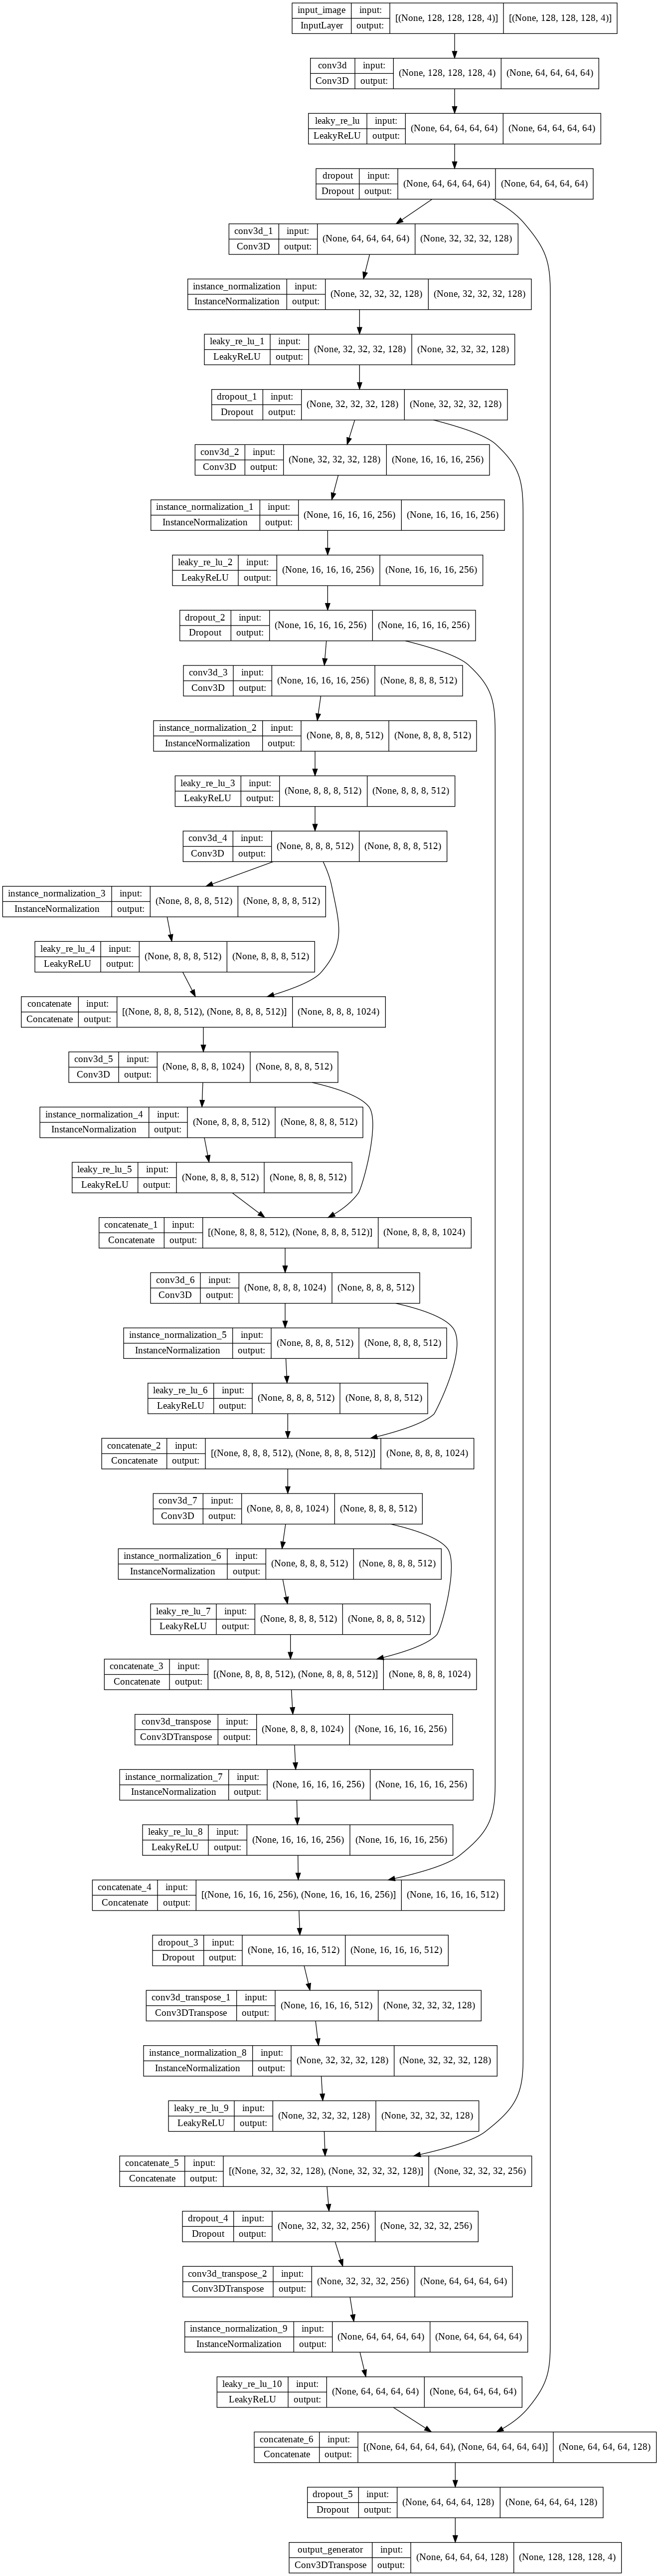

In [ ]:
from tensorflow.keras.utils import plot_model
G = Generator()
plot_model(G, to_file='gen_model.png', show_shapes=True)

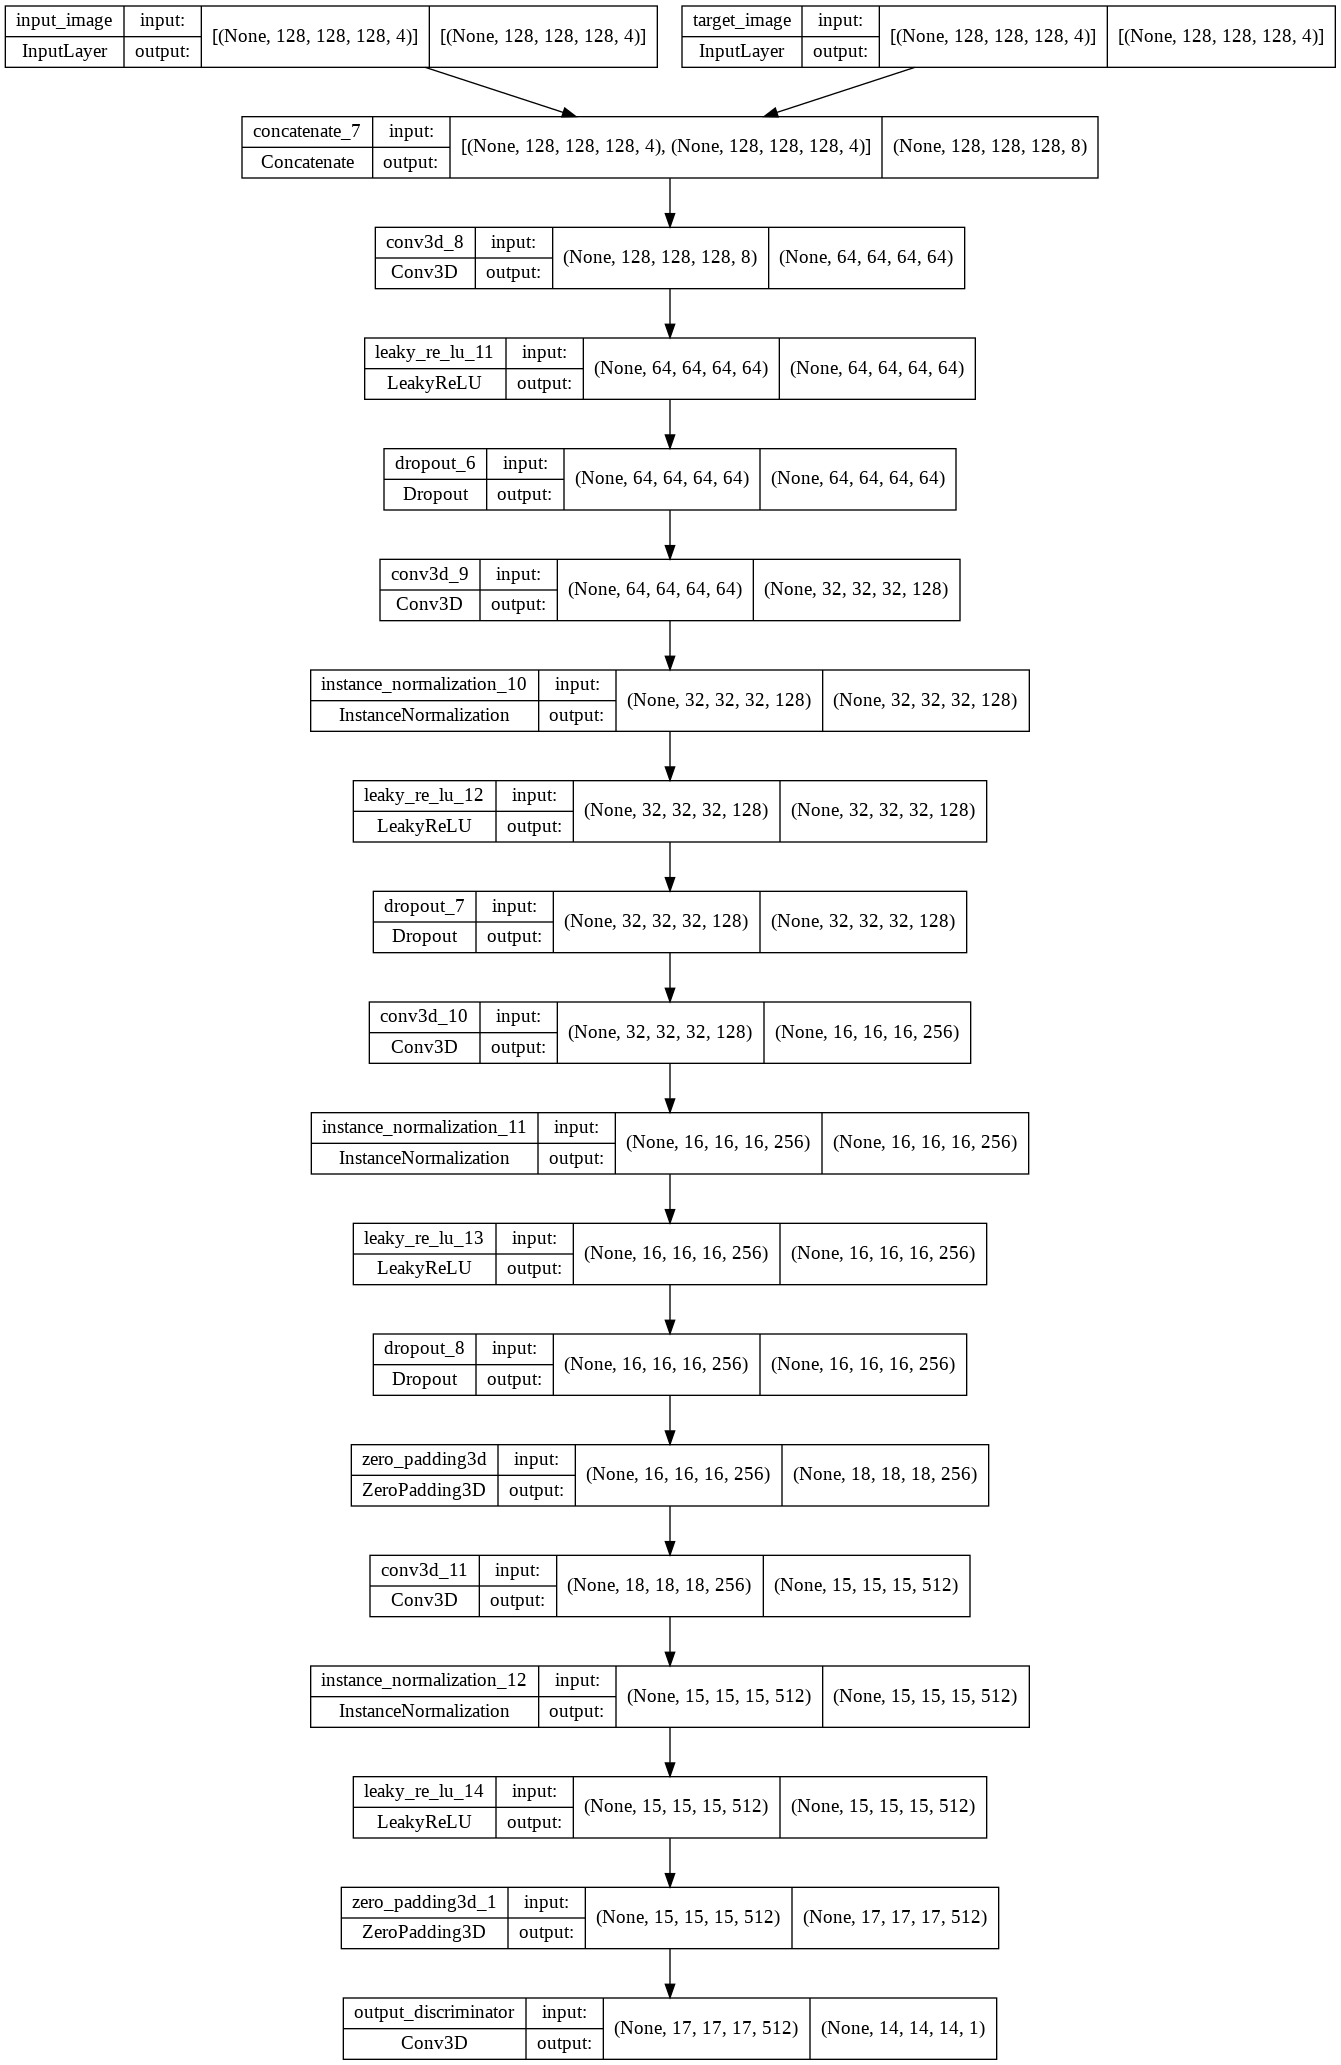

In [ ]:
from tensorflow.keras.utils import plot_model
D = Discriminator()
plot_model(D, to_file='disc_model.png', show_shapes=True)

In [ ]:
from array import *
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
class_weights=np.array([wt0, wt1, wt2, wt3])
class_weights = np.float32(class_weights)
class_weights

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [ ]:
#class_weights = np.load('/content/drive/MyDrive/DataSet/class_weights.npy')
#class_weights

In [ ]:
import os
import numpy as np
import tensorflow as tf
#from models import *
#from losses import *
import matplotlib.image as mpim
from sys import stdout


# class weights
class_weights = class_weights #np.load('/content/drive/MyDrive/DataSet/class_weights.npy')

# Models
G = Generator()
D = Discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(image, target, alpha):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = G(image, training=True)

        disc_real_output = D([image, target], training=True)
        disc_fake_output = D([image, gen_output], training=True)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        
        gen_loss, dice_loss, disc_loss_gen = generator_loss(target, gen_output, disc_fake_output, class_weights, alpha)

    generator_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, G.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, D.trainable_variables))
        
    return gen_loss, dice_loss, disc_loss_gen
        
@tf.function
def test_step(image, target, alpha):
    gen_output = G(image, training=False)

    disc_real_output = D([image, target], training=False)
    disc_fake_output = D([image, gen_output], training=False)
    disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
    #dice_coef = dice_coef(disc_real_output, disc_fake_output, smooth=1.0)

    gen_loss, dice_loss, disc_loss_gen = generator_loss(target, gen_output, disc_fake_output, class_weights, alpha)
        
    return gen_loss, dice_loss, disc_loss_gen

def fit(train_gen, valid_gen, alpha, epochs):
    
    path = '/content/drive/MyDrive/RESULTS27AUG' 
    if os.path.exists(path)==False:
        os.mkdir(path)
        
    Nt = len(train_gen)
    history = {'train': [], 'valid': []}
    prev_loss = np.inf
    
    epoch_v2v_loss = tf.keras.metrics.Mean()
    epoch_dice_loss = tf.keras.metrics.Mean()
    epoch_disc_loss = tf.keras.metrics.Mean()
    #epoch_dice_coeff = tf.keras.metrics.Mean()
    epoch_v2v_loss_val = tf.keras.metrics.Mean()
    epoch_dice_loss_val = tf.keras.metrics.Mean()
    epoch_disc_loss_val = tf.keras.metrics.Mean()
    #epoch_dice_coeff_val= tf.keras.metrics.Mean()
    
    for e in range(epochs):
        print('Epoch {}/{}'.format(e+1,epochs))
        b = 0
        for Xb, yb in train_gen:
            b += 1
            losses = train_step(Xb, yb, alpha)
            epoch_v2v_loss.update_state(losses[0])
            epoch_dice_loss.update_state(losses[1])
            epoch_disc_loss.update_state(losses[2])
            #epoch_dice_coeff.update_state(losses[3])

            stdout.write('\rBatch: {}/{} - loss: {:.4f} - dice_loss: {:.4f} - disc_loss: {:.4f} '
                         .format(b, Nt, epoch_v2v_loss.result(), epoch_dice_loss.result(), epoch_disc_loss.result()))
            stdout.flush()
        history['train'].append([epoch_v2v_loss.result(), epoch_dice_loss.result(), epoch_disc_loss.result()])
        
        for Xb, yb in valid_gen:
            losses_val = test_step(Xb, yb, alpha)
            epoch_v2v_loss_val.update_state(losses_val[0])
            epoch_dice_loss_val.update_state(losses_val[1])
            epoch_disc_loss_val.update_state(losses_val[2])
            #epoch_dice_coeff_val.update_state(losses[3])
            
        stdout.write('\n               loss_val: {:.4f} - dice_loss_val: {:.4f} - disc_loss_val: {:.4f} '
                     .format(epoch_v2v_loss_val.result(), epoch_dice_loss_val.result(), epoch_disc_loss_val.result()))
        stdout.flush()
        history['valid'].append([epoch_v2v_loss_val.result(), epoch_dice_loss_val.result(), epoch_disc_loss_val.result()])
        
        # save pred image at epoch e 
        y_pred = G.predict(Xb)
        y_true = np.argmax(yb, axis=-1)
        y_pred = np.argmax(y_pred, axis=-1)

        canvas = np.zeros((128, 128*3))
        idx = np.random.randint(len(Xb))
        
        x = Xb[idx,:,:,64,2] 
        canvas[0:128, 0:128] = (x - np.min(x))/(np.max(x)-np.min(x)+1e-6)
        canvas[0:128, 128:2*128] = y_true[idx,:,:,64]/3
        canvas[0:128, 2*128:3*128] = y_pred[idx,:,:,64]/3
        
        fname = (path + '/pred@no_aug_epoch_{:03d}.png').format(e+1)
        mpim.imsave(fname, canvas, cmap='gray')
        
        # save models
        print(' ')
        if epoch_v2v_loss_val.result() < prev_loss:    
            G.save_weights(path + '/Generator_no_aug.h5') 
            D.save_weights(path + '/Discriminator_no_aug.h5')
            print("Validation loss decresaed from {:.4f} to {:.4f}. Models' weights are now saved.".format(prev_loss, epoch_v2v_loss_val.result()))
            prev_loss = epoch_v2v_loss_val.result()
        else:
            print("Validation loss did not decrese from {:.4f}.".format(prev_loss))
        print(' ')
        
        # resets losses states
        epoch_v2v_loss.reset_states()
        epoch_dice_loss.reset_states()
        epoch_disc_loss.reset_states()
        epoch_v2v_loss_val.reset_states()
        epoch_dice_loss_val.reset_states()
        epoch_disc_loss_val.reset_states()
        
        del Xb, yb, canvas, y_pred, y_true, idx
        
    return history

In [ ]:
#!/usr/bin/env python
# coding: utf-8


#args = parser.parse_args()
gpu = 4
n_classes = 4
batch_size = 4
alpha = 5
n_epochs = 50


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu)

import tensorflow as tf
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import nibabel as nib
import glob
import time
from tensorflow.keras.utils import to_categorical
from sys import stdout
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from scipy.ndimage.interpolation import affine_transform
from sklearn.model_selection import train_test_split

#from utils import *
#from augmentation import *
#from losses import *
#from models import *
#from train_v2v import *

Nclasses = 4
classes = np.arange(Nclasses)
path = "/content/drive/MyDrive/DataSet/BraTS2021_TrainingData/"

# images lists
t1_list = sorted(glob.glob(path + '**/*t1.nii.gz'))
t2_list = sorted(glob.glob(path + '**/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(path + '**/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(path + '**/*flair.nii.gz'))
seg_list = sorted(glob.glob(path + '**/*seg.nii.gz'))

# create the training and validation sets
Nim = 50
idx = np.arange(Nim)

idxTrain, idxValid = train_test_split(idx, test_size=0.25)
sets = {'train': [], 'valid': []}

for i in idxTrain:
    sets['train'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
for i in idxValid:
    sets['valid'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
    
train_gen = DataGenerator(sets['train'], batch_size=batch_size, n_classes=n_classes, augmentation=True)
valid_gen = DataGenerator(sets['valid'], batch_size=batch_size, n_classes=n_classes, augmentation=True)

In [ ]:
import keras.backend as K
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
  # train the vox2vox model
h = fit(train_gen, valid_gen, alpha, n_epochs)

Epoch 1/50
Batch: 9/9 - loss: 6.3420 - dice_loss: 0.6688 - disc_loss: 2.9979 
               loss_val: 3.8258 - dice_loss_val: 0.5716 - disc_loss_val: 0.9677  
Validation loss decresaed from inf to 3.8258. Models' weights are now saved.
 
Epoch 2/50
Batch: 9/9 - loss: 3.5154 - dice_loss: 0.5339 - disc_loss: 0.8461 
               loss_val: 2.6312 - dice_loss_val: 0.4283 - disc_loss_val: 0.4898  
Validation loss decresaed from 3.8258 to 2.6312. Models' weights are now saved.
 
Epoch 3/50
Batch: 9/9 - loss: 3.8887 - dice_loss: 0.4119 - disc_loss: 1.8291 
               loss_val: 4.7984 - dice_loss_val: 0.3536 - disc_loss_val: 3.0304  
Validation loss did not decrese from 2.6312.
 
Epoch 4/50
Batch: 9/9 - loss: 2.9740 - dice_loss: 0.3563 - disc_loss: 1.1927 
               loss_val: 2.0126 - dice_loss_val: 0.2823 - disc_loss_val: 0.6012  
Validation loss decresaed from 2.6312 to 2.0126. Models' weights are now saved.
 
Epoch 5/50
Batch: 9/9 - loss: 2.1094 - dice_loss: 0.2915 - disc_loss: 

In [ ]:
#!/usr/bin/env python
# coding: utf-8


#args = parser.parse_args()
gpu = 8
n_classes = 4
batch_size = 4
alpha = 5
n_epochs = 25


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu)

import tensorflow as tf
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import nibabel as nib
import glob
import time
from tensorflow.keras.utils import to_categorical
from sys import stdout
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from scipy.ndimage.interpolation import affine_transform
from sklearn.model_selection import train_test_split

#from utils import *
#from augmentation import *
#from losses import *
#from models import *
#from train_v2v import *

Nclasses = 4
classes = np.arange(Nclasses)
path = "/content/drive/MyDrive/DataSet/BraTS2021_TrainingData/"

# images lists
t1_list = sorted(glob.glob(path + '**/*t1.nii.gz'))
t2_list = sorted(glob.glob(path + '**/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(path + '**/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(path + '**/*flair.nii.gz'))
seg_list = sorted(glob.glob(path + '**/*seg.nii.gz'))

# create the training and validation sets
Nim = 50
idx = np.arange(Nim)

idxTrain, idxValid = train_test_split(idx, test_size=0.25)
sets = {'train': [], 'valid': []}

for i in idxTrain:
    sets['train'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
for i in idxValid:
    sets['valid'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
    
train_gen = DataGenerator(sets['train'], batch_size=batch_size, n_classes=n_classes, augmentation=True)
valid_gen = DataGenerator(sets['valid'], batch_size=batch_size, n_classes=n_classes, augmentation=True)

In [ ]:
h2 = fit(train_gen, valid_gen, alpha, n_epochs)

Epoch 1/25
Batch: 9/9 - loss: 7.1869 - dice_loss: 0.7138 - disc_loss: 3.6177 
               loss_val: 4.0638 - dice_loss_val: 0.6415 - disc_loss_val: 0.8564  
Validation loss decresaed from inf to 4.0638. Models' weights are now saved.
 
Epoch 2/25
Batch: 9/9 - loss: 3.8313 - dice_loss: 0.6007 - disc_loss: 0.8278 
               loss_val: 2.9471 - dice_loss_val: 0.4921 - disc_loss_val: 0.4867  
Validation loss decresaed from 4.0638 to 2.9471. Models' weights are now saved.
 
Epoch 3/25
Batch: 9/9 - loss: 3.2752 - dice_loss: 0.4717 - disc_loss: 0.9169 
               loss_val: 2.5961 - dice_loss_val: 0.3745 - disc_loss_val: 0.7238  
Validation loss decresaed from 2.9471 to 2.5961. Models' weights are now saved.
 
Epoch 4/25
Batch: 9/9 - loss: 2.5213 - dice_loss: 0.3692 - disc_loss: 0.6752 
               loss_val: 1.9052 - dice_loss_val: 0.2949 - disc_loss_val: 0.4306  
Validation loss decresaed from 2.5961 to 1.9052. Models' weights are now saved.
 
Epoch 5/25
Batch: 9/9 - loss: 2.064

In [ ]:
!mkdir /content/drive/MyDrive/Training_checkpoints

In [ ]:

checkpoint_dir = '/content/drive/MyDrive/Training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=G,
                                 discriminator=D)

In [ ]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(checkpoint_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
from IPython import display
seed = tf.random.normal([num_examples_to_generate, noise_dim])
def train(train_gen, valid_gen, epochs):
  for epoch in range(epochs):
    start = time.time()

    for X,y in train_gen:
      train_step(X,y,alpha)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(G,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

 
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(G,
                           epochs,
                           seed)

In [ ]:
import numpy as np
import tensorflow as tf


#class_weights = np.load('class_weights.npy')

# Optimizers
ensembler_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

imShape = (128, 128, 128, 40)
gtShape = (128, 128, 128, 4)
#E = ensembler(imShape, gtShape, class_weights, kernel_size=3)                 

# Load the Vox2Vox models

gen1 = Generator()
gen1.load_weights('/content/drive/MyDrive/RESULTS/Generator1.h5')
print('Vox2Vox generator 1 loaded.')

gen2 = Generator()
gen2.load_weights('/content/drive/MyDrive/RESULTS/Generator2.h5')
print('Vox2Vox generator 2 loaded.')

gen3 = Generator()
gen3.load_weights('/content/drive/MyDrive/RESULTS/Generator3.h5')
print('Vox2Vox generator 3 loaded.')

# ## Training

def get_scores(X, y):

    SCORES = np.empty((X.shape[0], 128, 128, 128, 40))
    
    y_pred_1 = gen1.predict(X)
    SCORES[:,:,:,:,0:4] = y_pred_1
    del(y_pred_1)
    
    y_pred_2 = gen2.predict(X)
    SCORES[:,:,:,:,4:8] = y_pred_2
    del(y_pred_2)
    
    y_pred_3 = gen3.predict(X)
    SCORES[:,:,:,:,8:12] = y_pred_3
    del(y_pred_3)
    
    y_pred_4 = gen4.predict(X)
    SCORES[:,:,:,:,12:16] = y_pred_4
    del(y_pred_4)
    
   
    del(X, y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, y_pred_6, y_pred_7, y_pred_8, y_pred_9, y_pred_10)
    
    # pre-proc zero-center
    SCORES -= 0.5
    
    return SCORES
    


Vox2Vox generator 1 loaded.
Vox2Vox generator 2 loaded.
Vox2Vox generator 3 loaded.
